In [1]:
%matplotlib inline
import slug
import os
import glob
import h5py

import numpy as np

import matplotlib.pyplot as plt

from kungpao import io
from kungpao.display import display_single, IMG_CMAP, SEG_CMAP

from astropy.io import fits
from astropy import wcs
from astropy.table import Table, Column


from IPython.display import clear_output

# Download the HSC image of one given galaxy

In [2]:
ra_cen = 129.603676                  # ra of object
dec_cen = -1.606419                  # dec of object
redshift = 0.052043
url = slug.gen_url_hsc_s18a(ra_cen, dec_cen, 1200, 1200, 'r', pixel_unit=True)

### Login NAOJ account. You can replace the username and password by yours, instead of using a `config` file.

In [3]:
slug.login_naoj_server('/Users/jiaxuanli/Documents/HSC_config')

### Load image from the url and write it to h5 file

In [41]:
fits_data = fits.open(url[0], cache=False)

In [47]:
f = h5py.File('./HDF5/HSC_test.h5','w')
dt = h5py.special_dtype(vlen=str)

info = f.create_dataset('info', (10,2), dtype='S20')
info[0] = 'edition', 's18a'
info[1] = 'ra', ra_cen
info[2] = 'dec', dec_cen
info[3] = 'size (pix)', str([fits_data[1].shape[0], fits_data[1].shape[1]])
info[4] = 'redshift', redshift
g1 = f.create_group('Image')
g1.create_dataset('primary_header', data=fits_data[0].header.tostring(), dtype=dt)
g1.create_dataset('image', data=fits_data[1].data)
g1.create_dataset('image_header', data=fits_data[1].header.tostring(), dtype=dt)
g1.create_dataset('variance', data=fits_data[3].data)
g1.create_dataset('variance_header', data=fits_data[3].header.tostring(), dtype=dt)

f.close()

In [48]:
f = h5py.File('./HDF5/HSC_test.h5', 'r')
print(f['info'][:])
f.close()

[['edition' 's18a']
 ['ra' '129.603676']
 ['dec' '-1.606419']
 ['size (pix)' '[2401, 2401]']
 ['redshift' '0.052043']
 ['' '']
 ['' '']
 ['' '']
 ['' '']
 ['' '']]


### 1-D profile

('At redshift', 0.052043, ', 1 arcsec =', 1.0149765914580582, 'kpc')


# Detect 656 objects
# Detect 978 objects
# Mean Sky / RMS Sky =    0.00248 /    0.05275


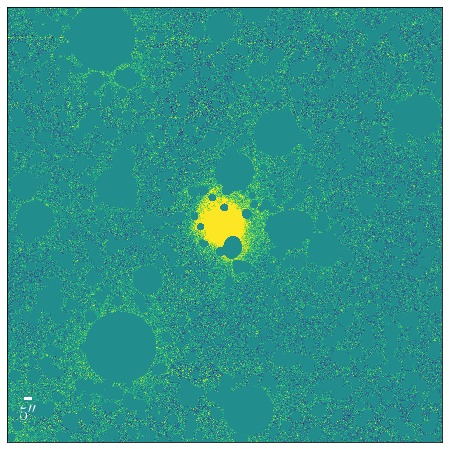

./Masks/HSC_test_msk.fits -> temp_RN94N.fits.pl
./Masks/HSC_test_msk.fits -> temp_RN94N.pl
----------------------------------------------------------------------------------------------------
###      galX, galY :  1200 1200
###      galR :  20.0
###      iniSma, maxSma :  10.0 900.0
###      Stage :  2
###      Step :  0.1
----------------------------------------------------------------------------------------------------
##       Set up the Ellipse configuration

----------------------------------------------------------------------------------------------------
##       Start the Ellipse Run: Attempt  1
----------------------------------------------------------------------------------------------------
###      Origin Image  : ./Images/HSC_test_img.fits
###      Input Image   : temp_RN94N.fits
###      Output Binary : ./Images/HSC_test_img_ellip_2.bin
----------------------------------------------------------------------------------------------------
###     Input background value  

In [49]:
prefix = 'HSC_test'

f = h5py.File('./HDF5/HSC_test.h5', 'r+')

img = f['Image']['image'].value
w = wcs.WCS(f['Image']['image_header'].value)
g4 = f.create_group('Mask')
g5 = f.create_group('MaskedImage')

# phys_size
redshift = float(f['info'][4,1])
phys_size = slug.phys_size(redshift)

# extract obj
data = img
data = data.byteswap().newbyteorder()
objects, segmap = slug.extract_obj(
    data,
    b=30,
    f=5,
    sigma=5,
    pixel_scale=slug.HSC_pixel_scale,
    deblend_cont=0.1,
    deblend_nthresh=20,
    show_fig=False)

# make mask
seg_mask = slug.make_binary_mask(data, w, segmap, show_fig=False, factor_b=1.2, threshold=0.01)
objects, segmap = slug.extract_obj(data, b=30, f=5, sigma=3, pixel_scale=slug.HSC_pixel_scale,
    deblend_cont=0.1, deblend_nthresh=20, show_fig=False)
seg_mask_2 = slug.make_binary_mask(data, w, segmap, show_fig=False, factor_b=1.2, threshold=0.01)
seg_mask = seg_mask + seg_mask_2

# evaluate_sky
bkg_global = slug.evaluate_sky(data, show_fig=False, show_hist=False)

f['info'][5] = 'global bkg', bkg_global.globalback
f['info'][6] = 'global rms', bkg_global.globalrms

g4.create_dataset('mask', data=seg_mask)
g5.create_dataset('maskedimage', data=data*(~seg_mask))

# Save image and mask
if not os.path.isdir('Images'):
    os.mkdir('Images')
if not os.path.isdir('Masks'):
    os.mkdir('Masks')
img_fits = './Images/' + prefix + '_img.fits'
msk_fits = './Masks/' + prefix + '_msk.fits'
io.save_to_fits(data, img_fits, wcs=w)
io.save_to_fits(seg_mask.astype('uint8'), msk_fits, wcs=w)

display_single(data*(~seg_mask))
plt.show(block=False)

# Run ELLIPSE
iraf_path = '/Users/jiaxuanli/Research/slug/slug/iraf/macosx/'
ell_free, ell_fix = slug.run_SBP(
    img_fits,
    msk_fits,
    slug.HSC_pixel_scale,
    phys_size,
    iraf_path,
    step=0.1,
    n_clip=3,
    low_clip=3.0,
    upp_clip=2.5,
    outPre=prefix)
f['info'][7] = 'mean_e', ell_fix['ell'][10]
f['info'][8] = 'mean_pa', ell_fix['pa'][10]
f.create_dataset('ell_fix', data=ell_fix)
f.create_dataset('ell_free', data=ell_free)

f.close()

In [7]:
f = h5py.File('./HDF5/HSC_test.h5', 'r')
slug.h5_print_attrs(f)
print(f['info'].value)
f.close()

Image
Image/image
Image/image_header
Image/primary_header
Image/variance
Image/variance_header
Mask
Mask/mask
MaskedImage
MaskedImage/maskedimage
ell_fix
ell_free
info
[['edition' 's18a']
 ['ra' '129.603676']
 ['dec' '-1.606419']
 ['size (pix)' '[2401, 2401]']
 ['redshift' '0.052043']
 ['global bkg' '0.00248484592885']
 ['global rms' '0.0527527332306']
 ['mean_e' '0.14']
 ['mean_pa' '-31.73']
 ['' '']]


## Subtract the mean value of nearby sky objects

In [3]:
from astropy.coordinates import match_coordinates_sky
from astropy import units as u
from astropy.coordinates import SkyCoord
sky_cat = Table.read('/Users/jiaxuanli/Research/HSC_Dragonfly_DECaLS/s18a_wide_skyobject_flux.fits', format='fits')

In [4]:
f = h5py.File('./HDF5/HSC_test.h5', 'r')
ra, dec = float(f['info'][1,1]), float(f['info'][2,1])

bkg_pos = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
catalog = SkyCoord(ra=sky_cat['i_ra']*u.degree, dec=sky_cat['i_dec']*u.degree)
obj_inx = np.where(catalog.separation(bkg_pos)<3*u.arcmin)[0]

print('sky objects number:', len(obj_inx))
print (sky_cat[obj_inx]['r_apertureflux_40_flux']*1.7378e30/(np.pi*12**2)).mean()
print (sky_cat[obj_inx]['r_apertureflux_57_flux']*1.7378e30/(np.pi*17**2)).mean()

off_set = (sky_cat[obj_inx]['r_apertureflux_57_flux']*1.7378e30/(np.pi*17**2)).mean()

/anaconda3/envs/iraf27/lib/python2.7/site-packages/astropy/coordinates/angles.py:651: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/anaconda3/envs/iraf27/lib/python2.7/site-packages/astropy/coordinates/angles.py:651: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/anaconda3/envs/iraf27/lib/python2.7/site-packages/astropy/coordinates/angles.py:534: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/anaconda3/envs/iraf27/lib/python2.7/site-packages/astropy/coordinates/angles.py:534: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):


('sky objects number:', 27)
0.008036291272492786
0.008721959690797197


/anaconda3/envs/iraf27/lib/python2.7/site-packages/astropy/units/quantity.py:641: RuntimeWarning: invalid value encountered in less
  *arrays, **kwargs)


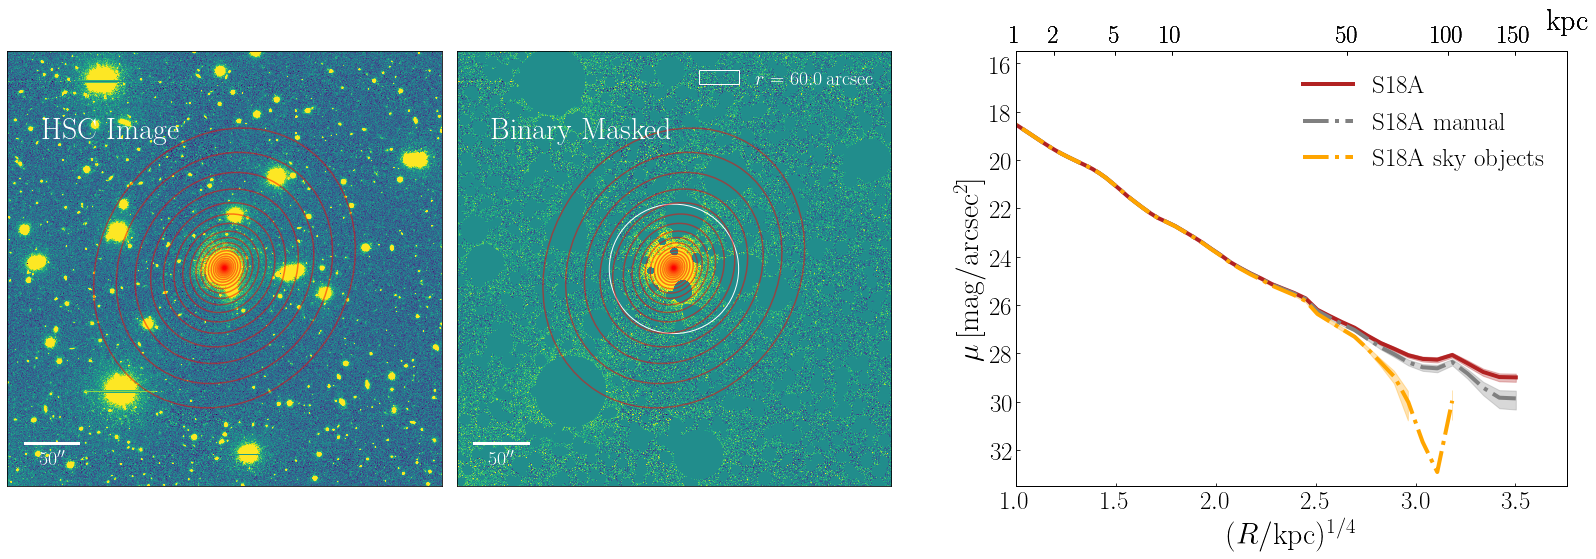

In [11]:
s18a_ellipse_fix = f['ell_fix'].value
img = f['Image']['image'].value
masked_img = f['MaskedImage']['maskedimage'].value

fig = plt.figure(figsize=(28, 8))
grid = plt.GridSpec(1, 14, wspace=0.1, hspace=0.1)

ax1 = fig.add_subplot(grid[0, 0:4])
ax1 = slug.display_isophote(
    img,
    s18a_ellipse_fix,
    slug.HSC_pixel_scale,
    text='HSC\ Image',
    ax=ax1)

ax2 = fig.add_subplot(grid[0, 4:8])
ax2 = slug.display_isophote(
    masked_img,
    s18a_ellipse_fix,
    slug.HSC_pixel_scale,
    text='Binary\ Masked',
    ax=ax2,
    circle=60)

ax3 = fig.add_subplot(grid[0, 9:])
ax3.tick_params(direction='in')

slug.SBP_single(s18a_ellipse_fix, redshift, slug.HSC_pixel_scale, slug.HSC_zeropoint, ax=ax3,
    physical_unit=True, x_max=(200**0.25), vertical_line=False, show_dots=False, linecolor='firebrick',
    linestyle='-', label="S18A")
slug.SBP_single(s18a_ellipse_fix, redshift, slug.HSC_pixel_scale, slug.HSC_zeropoint, ax=ax3, offset=-float(f['info'].value[5][1]),
    physical_unit=True, x_max=(200**0.25), vertical_line=False, show_dots=False, linecolor='gray',
    linestyle='-.', label="S18A\ manual")
slug.SBP_single(s18a_ellipse_fix, redshift, slug.HSC_pixel_scale, slug.HSC_zeropoint, ax=ax3, offset=-off_set,
    physical_unit=True, x_max=(200**0.25), vertical_line=False, show_dots=False, linecolor='orange',
    linestyle='-.', label="S18A\ sky\ objects")

plt.ylim(15.5, 33.5)
#plt.vlines((100 * 0.168)**0.25, 15.5, 32.5, linestyle='-.', label='60 arcsec')
ax3.invert_yaxis()
plt.subplots_adjust(hspace=0.)
#f.close()
#plt.savefig('./Figures/' + prefix + '.png', dpi=100, bbox_inches='tight')

In [ ]:
f.close()